In [2]:
import pandas as pd
import numpy as np
import torch as th
import dgl

In [3]:
df = pd.read_csv('test_pred.csv')

In [4]:
df['diff'] = abs(df.predict - df.label)

In [5]:
df

,user_id,movie_id,predict,label,diff
0,8557,6677,3.254683,3.5,0.245317
1,5108,6677,3.542311,3.5,0.042311
2,2487,6677,3.033718,3.5,0.466282
3,6613,6677,3.292193,3.0,0.292193
4,8103,12292,4.227084,3.5,0.727084
...,...,...,...,...,...
28761,2495,16971,3.447613,5.0,1.552387
28762,2495,5423,2.329284,3.5,1.170716
28763,7229,13424,2.683071,3.0,0.316929
28764,7229,13424,2.683071,3.0,0.316929


In [6]:
df.sort_values('predict')

,user_id,movie_id,predict,label,diff
22633,9007,1426,0.878051,1.0,0.121949
23070,2343,8624,0.896164,1.5,0.603836
26199,2463,1426,0.975067,0.5,0.475067
11888,4509,5383,0.975411,1.0,0.024589
15612,6743,3065,0.983832,0.5,0.483832
...,...,...,...,...,...
28070,9271,8985,5.272478,5.0,0.272478
16501,9271,629,5.294309,5.0,0.294309
28086,9271,600,5.322896,5.0,0.322896
28090,9271,690,5.369178,5.0,0.369178


In [7]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화

# 잘 예측한 행(u_id: 1489, m_id: 13218)에 1홉으로 연결된 서브그래프를 시각화

In [8]:
df.query('user_id==2001 and movie_id==13301', engine='python')

,user_id,movie_id,predict,label,diff
8901,2001,13301,4.145018,0.5,3.645018
8907,2001,13301,4.169847,0.5,3.669847


In [9]:
df.query('user_id==1489 and movie_id==13218', engine='python')

,user_id,movie_id,predict,label,diff
22911,1489,13218,3.000018,3.0,0.000018
22912,1489,13218,3.000007,3.0,0.000007


In [10]:
def map_newid(df, col):
    old_ids = df[col]
    old_id_uniq = old_ids.unique()

    id_dict = {old: new for new, old in enumerate(sorted(old_id_uniq))}
    new_ids = np.array([id_dict[x] for x in old_ids])

    return new_ids

In [11]:
#build graph 

from graph_data import UserItemGraph
user_item_graph = UserItemGraph(label_col='label', user_col='user_id', item_col='movie_id', edge_feature_col='label', data_path='test_pred.csv')

In [12]:
df['new_uid'] = map_newid(df, 'user_id')
df['new_iid'] = map_newid(df, 'movie_id')
df

,user_id,movie_id,predict,label,diff,new_uid,new_iid
0,8557,6677,3.254683,3.5,0.245317,632,2534
1,5108,6677,3.542311,3.5,0.042311,380,2534
2,2487,6677,3.033718,3.5,0.466282,153,2534
3,6613,6677,3.292193,3.0,0.292193,488,2534
4,8103,12292,4.227084,3.5,0.727084,605,4390
...,...,...,...,...,...,...,...
28761,2495,16971,3.447613,5.0,1.552387,154,5630
28762,2495,5423,2.329284,3.5,1.170716,154,2095
28763,7229,13424,2.683071,3.0,0.316929,532,4790
28764,7229,13424,2.683071,3.0,0.316929,532,4790


In [13]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==2001 and movie_id==13301', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
8901,2001,13301,4.145018,0.5,3.645018,115,4752
8907,2001,13301,4.169847,0.5,3.669847,115,4752


In [14]:
# 잘 예측한 행(u_id: 1489, m_id: 13218)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==1489 and movie_id==13218', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
22911,1489,13218,3.000018,3.0,0.000018,87,4726
22912,1489,13218,3.000007,3.0,0.000007,87,4726


## 서브그래프 시각화 코드

In [15]:
import networkx as nx
import matplotlib.pyplot as plt


def graph_to_nx(subgraph:dgl.heterograph, sample_edge_num=100) -> (nx.Graph, list) :

    item_ids = subgraph.ndata['_ID']['item']
    user_ids = subgraph.ndata['_ID']['user']
    u_idx, i_idx = subgraph.edges()
    
    #sampling based on edge
    u_idx, i_idx = u_idx.tolist()[:sample_edge_num], i_idx.tolist()[:sample_edge_num]

    #switch to original value
    origin_u_idx = user_ids[u_idx].tolist()
    origin_i_idx = item_ids[i_idx].tolist()
    edge_labels = subgraph.edata['label'].tolist()

    edge_weight_set = [(u,v,{'rating':r}) for u,v,r in zip(origin_i_idx, origin_u_idx, edge_labels)]
    
    g = nx.Graph()

    u_nodes = list(set(origin_u_idx)) 
    
    g.add_nodes_from(list(set(origin_u_idx)), bipartite=0, label='user')
    g.add_nodes_from(list(set(origin_i_idx)), bipartite=1, label='item')
    # TODO : change edge weight key string
    g.add_edges_from(edge_weight_set)

    return g, u_nodes


def draw_bt_graph(g:nx.Graph, u_nodes, show_rating=False) -> None:
    pos = nx.bipartite_layout(g, u_nodes)
    plt.figure(figsize=[15,15])

    if show_rating:
        edge_labels = nx.get_edge_attributes(g, 'rating')
    else:
        edge_labels = {}
        
#     graph = nx.draw_networkx_edges(g, pos, edge_labels=edge_labels)
    graph = nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
    edges = g.edges()
    edge_colors = [g[u][v]['rating'] for u,v in edges]
    
    # Pass that layout to nx.draw
    nx.draw(g,pos,node_color='#A0CBE2',edge_color=edge_colors, width=1,
            edge_cmap=plt.cm.coolwarm,with_labels=True)
    edges2 = nx.draw_networkx_edges(g,pos,edge_color=edge_colors,width=4,
                                   edge_cmap=plt.cm.coolwarm)
    v = np.linspace(start=0.0, stop=5.0,num=5,endpoint=True)
    plt.colorbar(edges2, ticks=v)
    plt.draw()

## 1. 잘못 예측한 행에 1홉으로 연결된 서브그래프를 시각화
- (u_id: 2001, m_id: 13301)

In [16]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==2001 and movie_id==13301', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
8901,2001,13301,4.145018,0.5,3.645018,115,4752
8907,2001,13301,4.169847,0.5,3.669847,115,4752


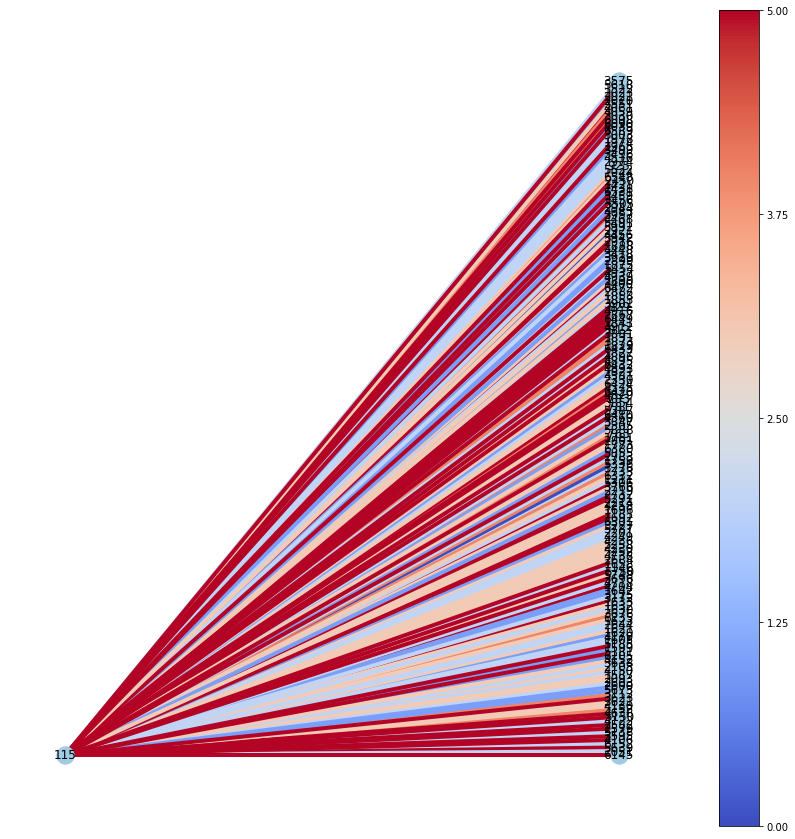

In [17]:
from graph_data import *

# 1489, 13218
user = th.tensor(115, dtype=th.int32)
item = th.tensor(4752, dtype=th.int32)

u_nodes, i_nodes, = get_neighbor_nodes_labels(u_nodes=user, 
                                              i_nodes=item,
                                              graph=user_item_graph.bt_graph, 
                                              hop=1
                                              )
sub_graph = dgl.node_subgraph(user_item_graph.bt_graph, {'user':u_nodes, 'item':i_nodes}, store_ids=True)
g, n = graph_to_nx(sub_graph, sample_edge_num=200)
draw_bt_graph(g, n)

## 2. 잘 예측한 행에 1홉으로 연결된 서브그래프를 시각화
- (u_id: 1489, m_id: 13218)

In [18]:
# 잘 예측한 행(u_id: 1489, m_id: 13218)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==1489 and movie_id==13218', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
22911,1489,13218,3.000018,3.0,0.000018,87,4726
22912,1489,13218,3.000007,3.0,0.000007,87,4726


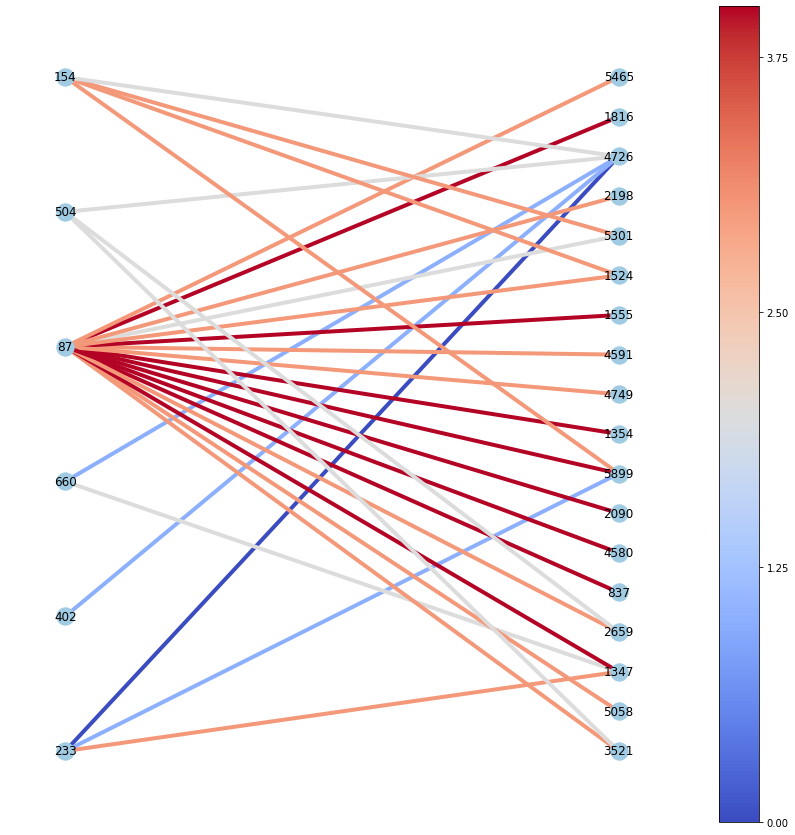

In [19]:
from graph_data import *

# 1489, 13218
user = th.tensor(87, dtype=th.int32)
item = th.tensor(4726, dtype=th.int32)

u_nodes, i_nodes, = get_neighbor_nodes_labels(u_nodes=user, 
                                              i_nodes=item,
                                              graph=user_item_graph.bt_graph, 
                                              hop=1
                                              )
sub_graph = dgl.node_subgraph(user_item_graph.bt_graph, {'user':u_nodes, 'item':i_nodes}, store_ids=True)
g, n = graph_to_nx(sub_graph, sample_edge_num=100)
draw_bt_graph(g, n)

## 3. 높은 평점 예측
- (u_id: 9271, m_id: 8250) 

In [20]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==9271 and movie_id==8250', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
28091,9271,8250,5.505431,5.0,0.505431,696,3050


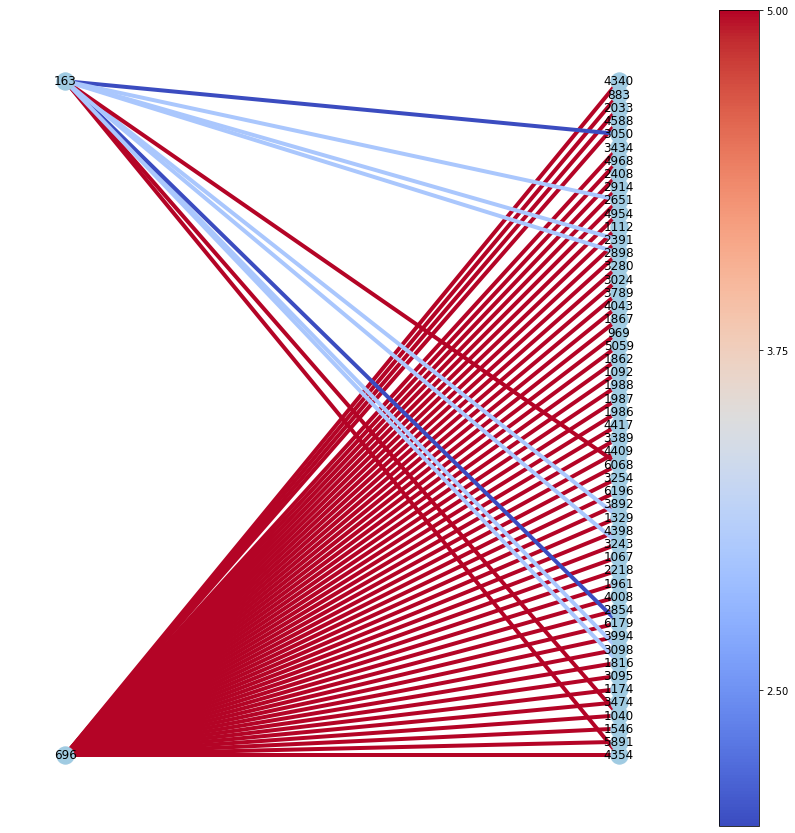

In [27]:
from graph_data import *

# 1489, 13218
user = th.tensor(696, dtype=th.int32)
item = th.tensor(3050, dtype=th.int32)

u_nodes, i_nodes, = get_neighbor_nodes_labels(u_nodes=user, 
                                              i_nodes=item,
                                              graph=user_item_graph.bt_graph, 
                                              hop=1
                                              )
sub_graph = dgl.node_subgraph(user_item_graph.bt_graph, {'user':u_nodes, 'item':i_nodes}, store_ids=True)
g, n = graph_to_nx(sub_graph, sample_edge_num=1000)
draw_bt_graph(g, n)

## 4. 낮은 평점 예측
- (u_id: 9007, m_id: 1426)

In [22]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==9007 and movie_id==1426', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
22633,9007,1426,0.878051,1.0,0.121949,667,843


In [23]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==6743 and movie_id==3065', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
15612,6743,3065,0.983832,0.5,0.483832,495,1267


In [24]:
# 잘못 예측한 행(u_id: 2001, m_id: 13301)에 1홉으로 연결된 서브그래프를 시각화
df.query('user_id==4509 and movie_id==5383', engine='python')

,user_id,movie_id,predict,label,diff,new_uid,new_iid
11888,4509,5383,0.975411,1.0,0.024589,330,2079


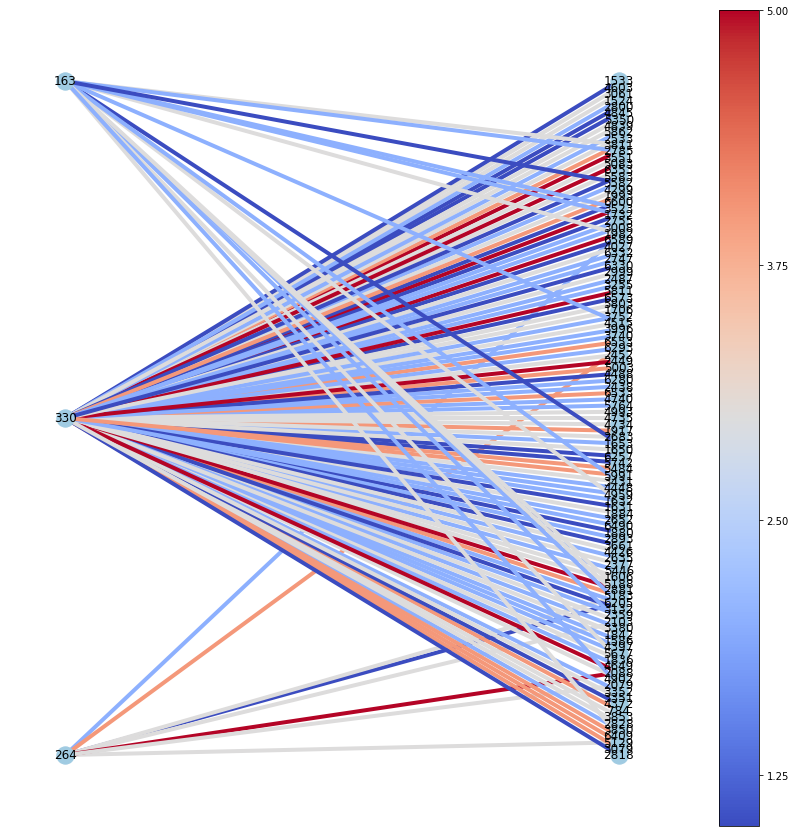

In [26]:
from graph_data import *

# 1489, 13218
user = th.tensor(330, dtype=th.int32)
item = th.tensor(2079, dtype=th.int32)

u_nodes, i_nodes, = get_neighbor_nodes_labels(u_nodes=user, 
                                              i_nodes=item,
                                              graph=user_item_graph.bt_graph, 
                                              hop=1
                                              )
sub_graph = dgl.node_subgraph(user_item_graph.bt_graph, {'user':u_nodes, 'item':i_nodes}, store_ids=True)
g, n = graph_to_nx(sub_graph, sample_edge_num=1000)
draw_bt_graph(g, n)